Loaded dataset with shape: (400, 19)

Columns: ['Student_ID', 'Age', 'Gender', 'High_School_GPA', 'SAT_Score', 'University_GPA', 'Field_of_Study', 'Internships_Completed', 'Projects_Completed', 'Certifications', 'Soft_Skills_Score', 'Networking_Score', 'Job_Offers', 'Starting_Salary', 'Career_Satisfaction', 'Years_to_Promotion', 'Current_Job_Level', 'Work_Life_Balance', 'Entrepreneurship']

Sample rows:
   Student_ID  Age  Gender  High_School_GPA  SAT_Score  University_GPA  \
0       S001   22    Male              3.8       1450             3.6   
1       S002   24  Female              3.6       1380             3.4   
2       S003   21    Male              3.9       1520             3.8   
3       S004   23  Female              3.5       1300             3.2   
4       S005   25    Male              3.7       1420             3.5   

     Field_of_Study  Internships_Completed  Projects_Completed  \
0  Computer Science                      3                   7   
1          Business  

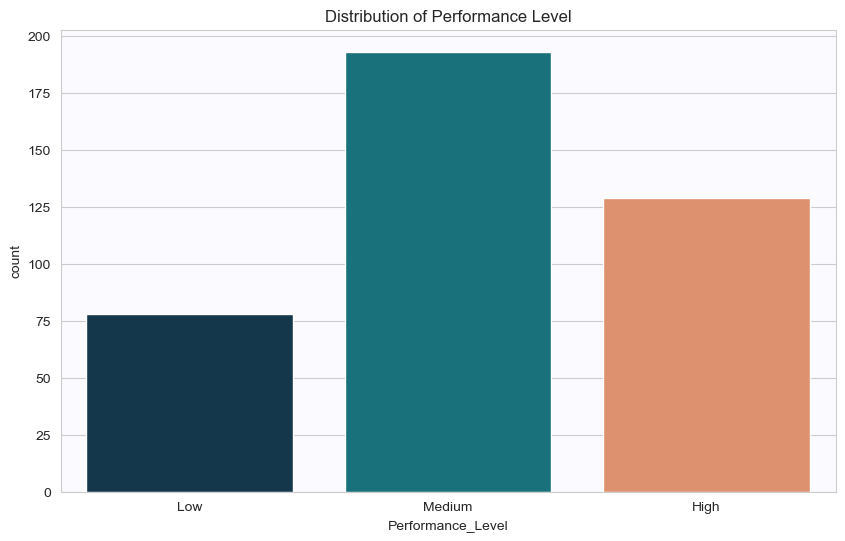

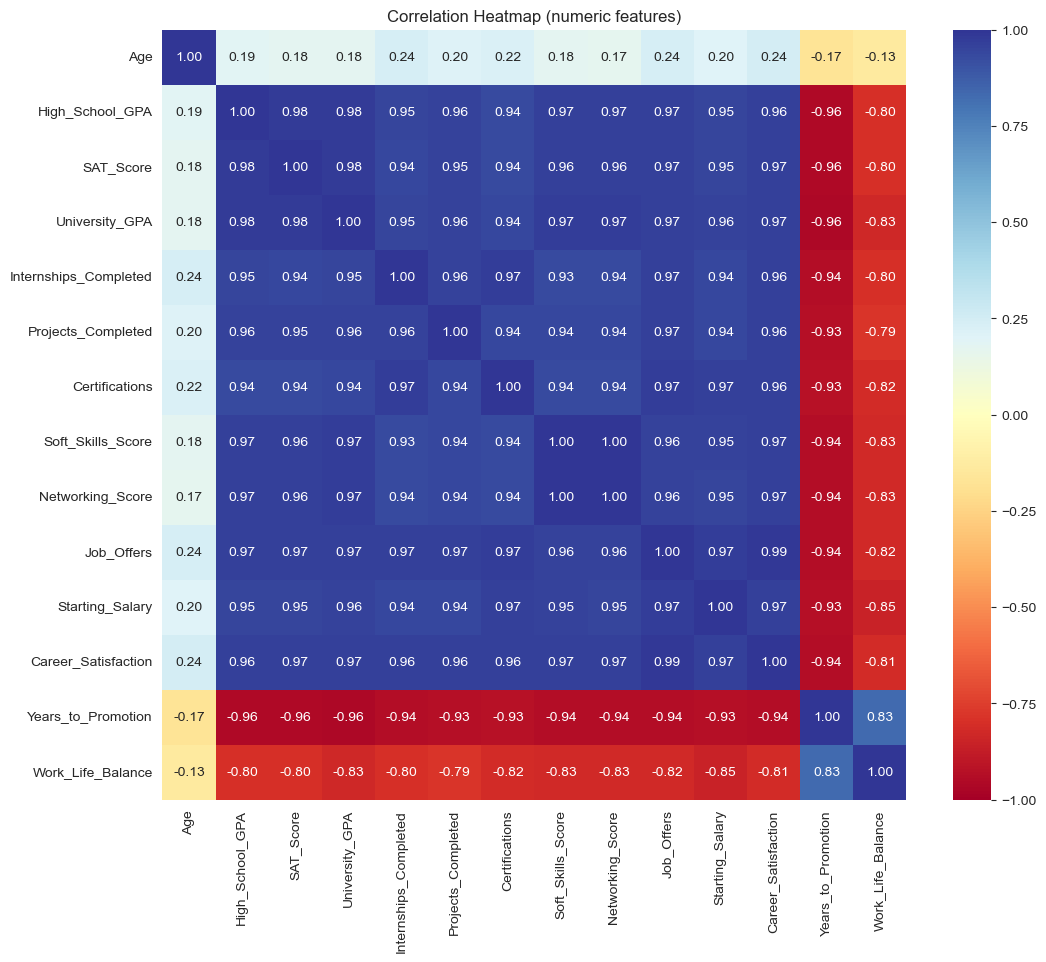

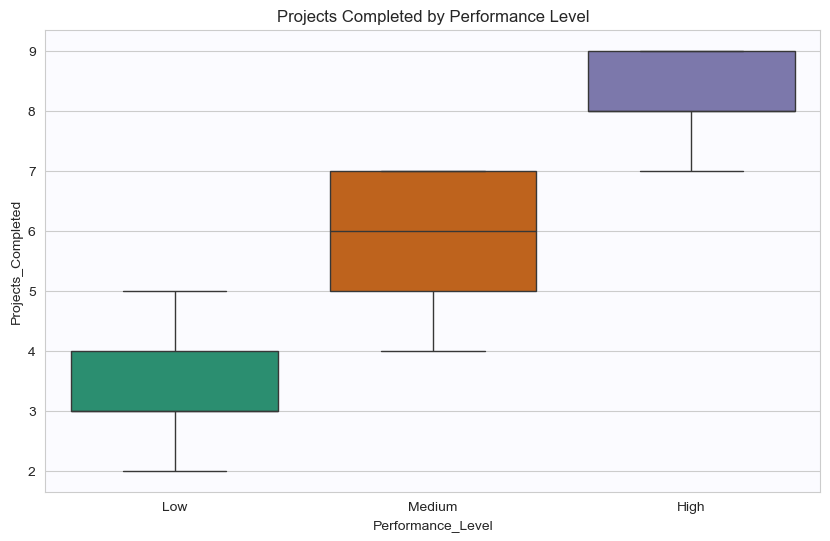

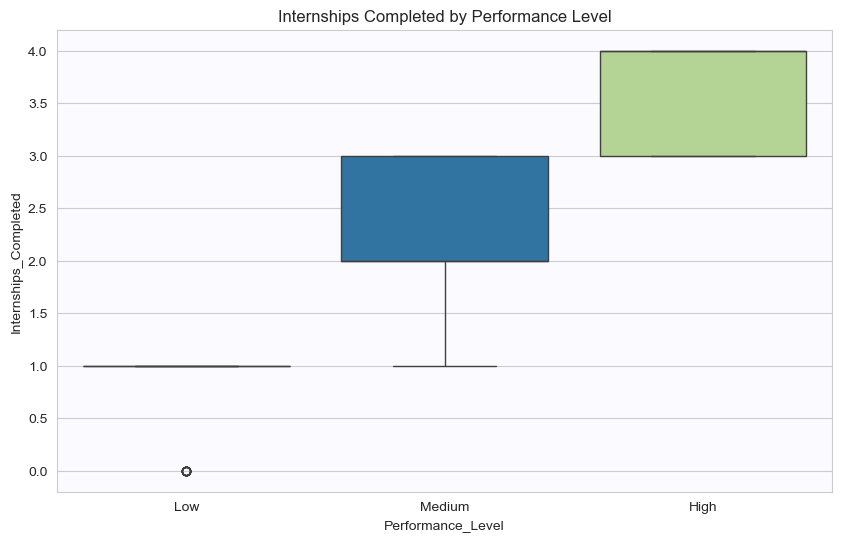

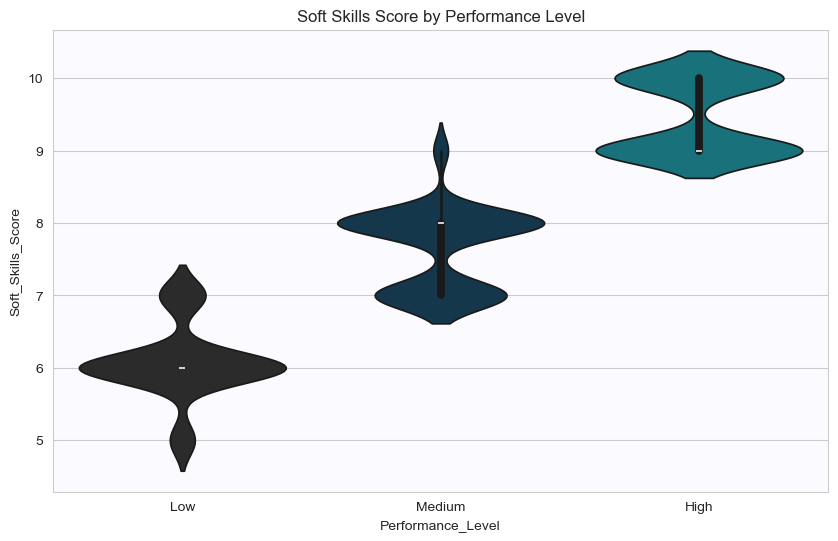

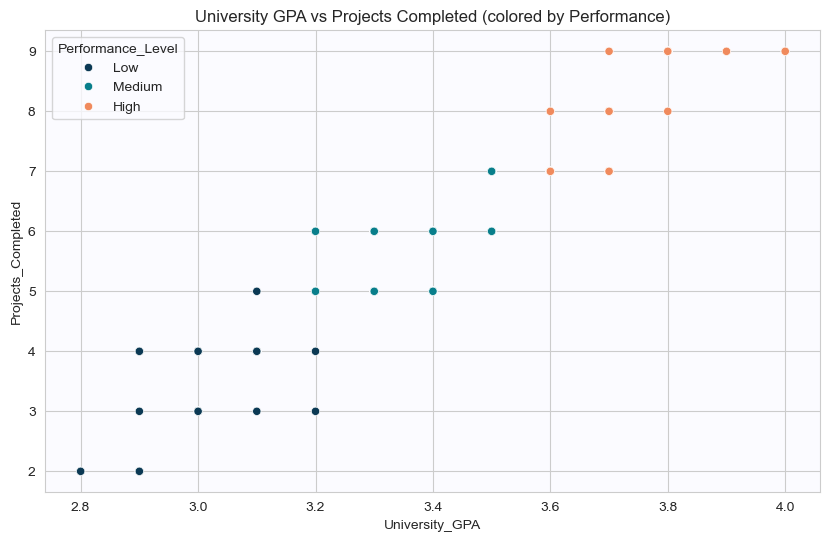

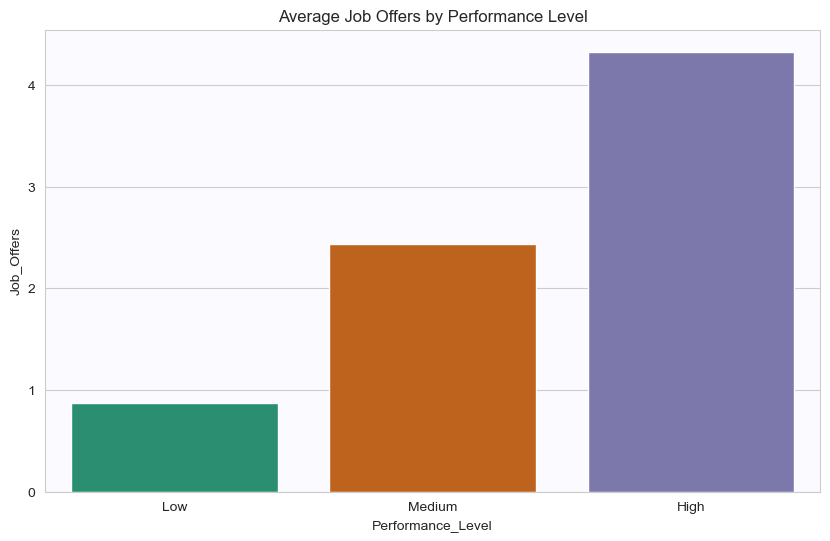

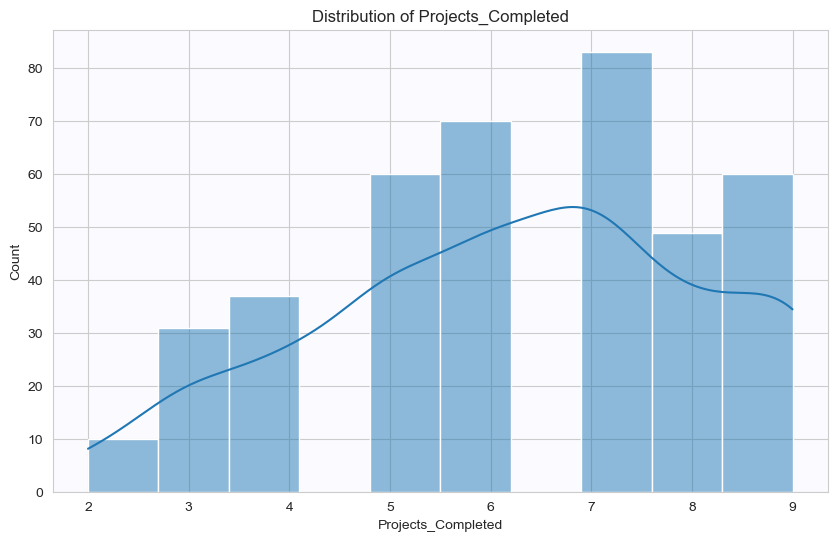

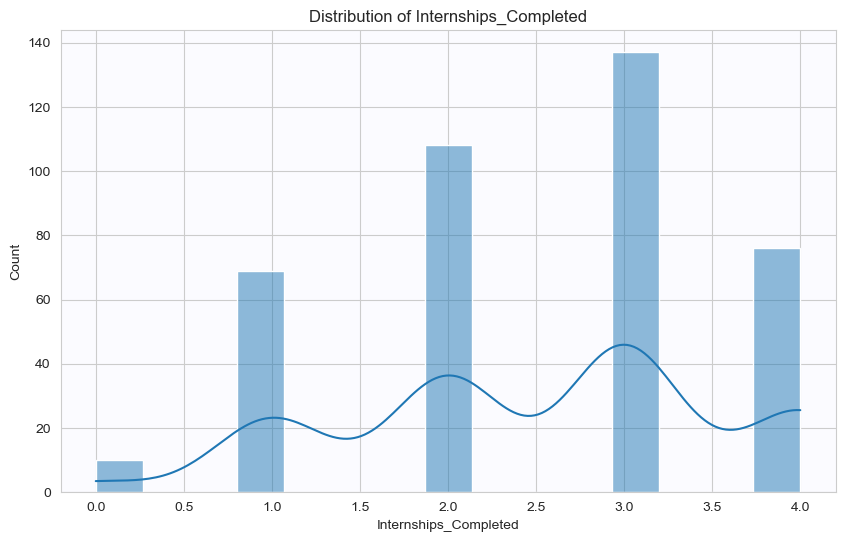

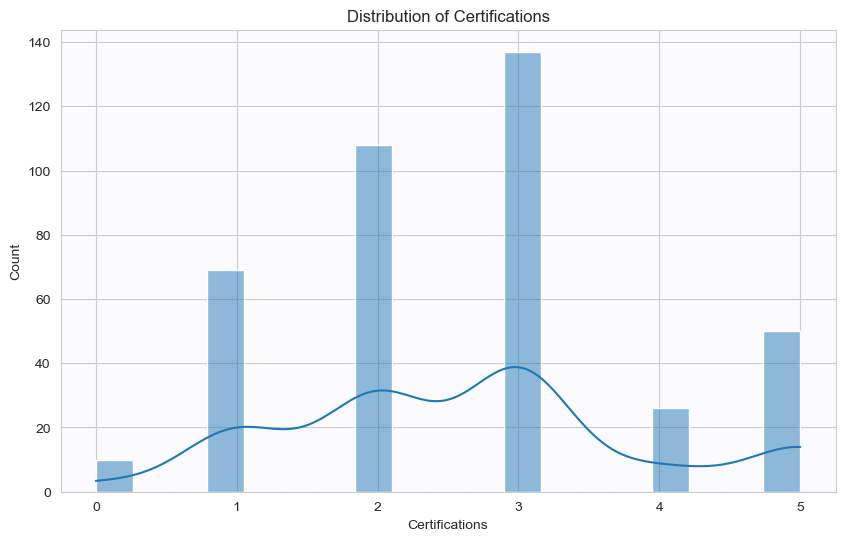

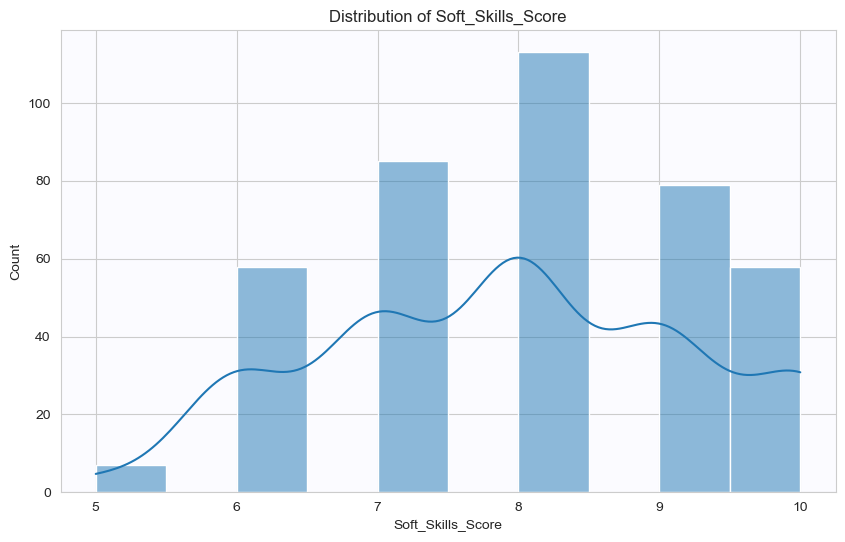

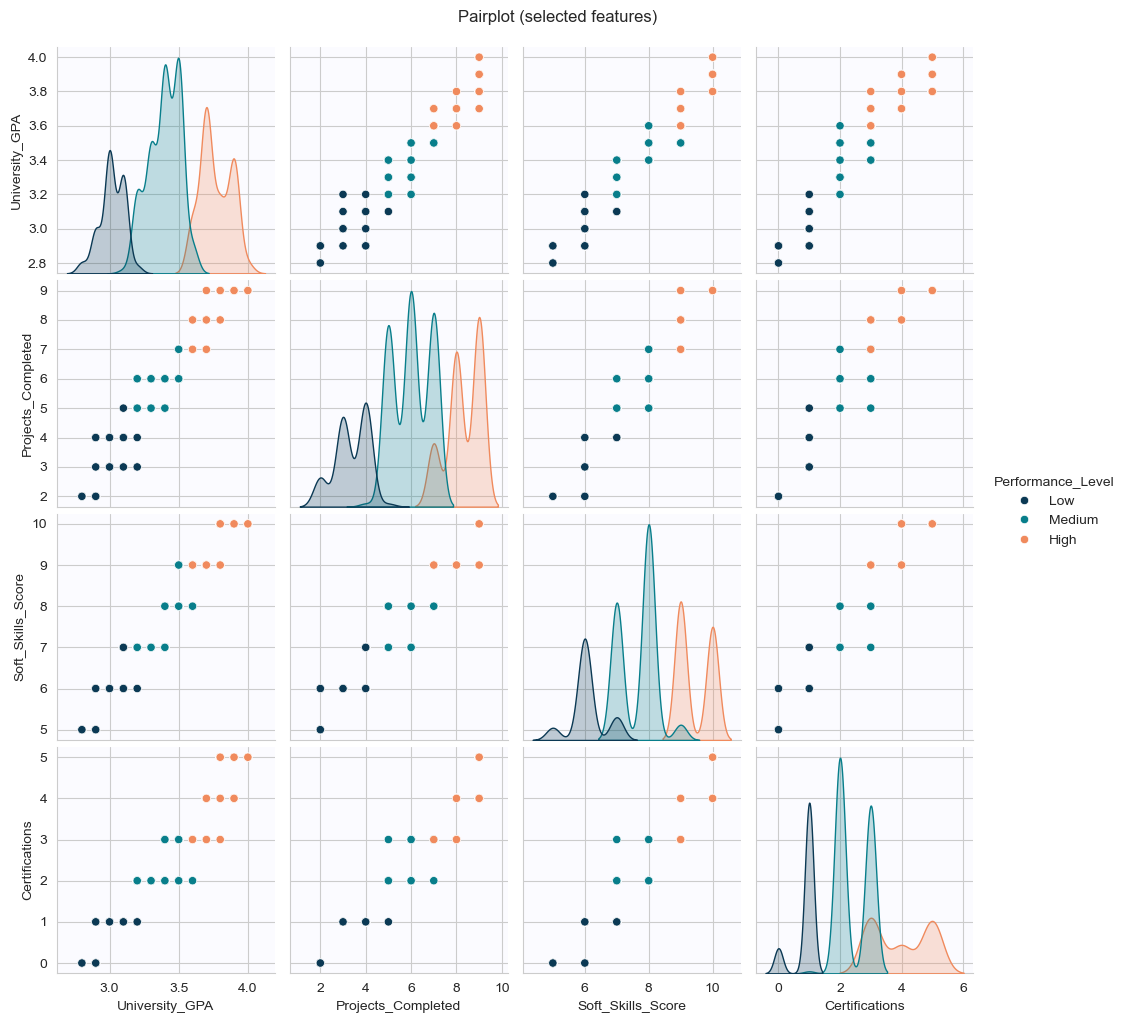

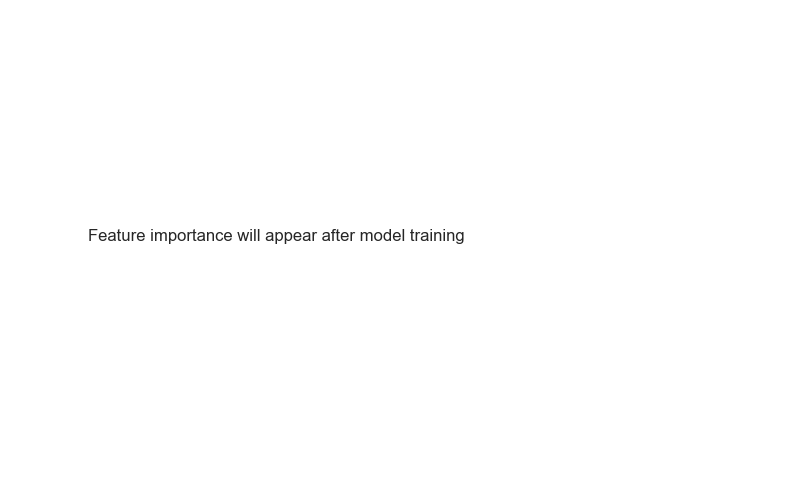

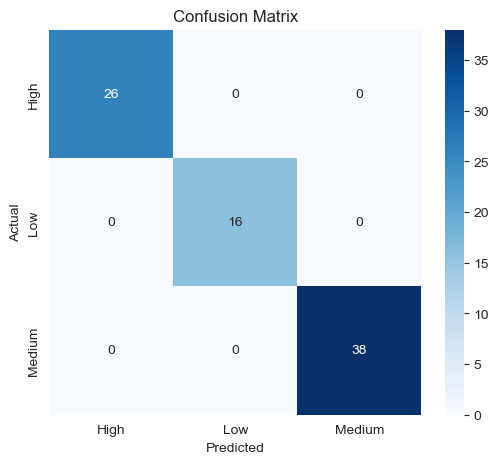

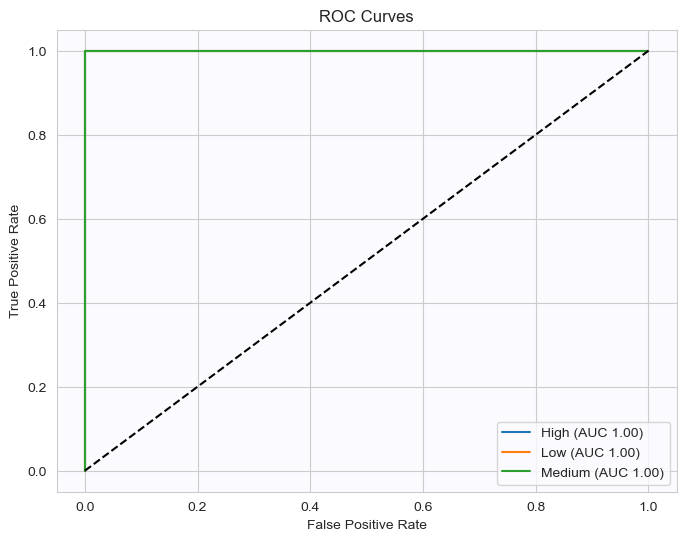

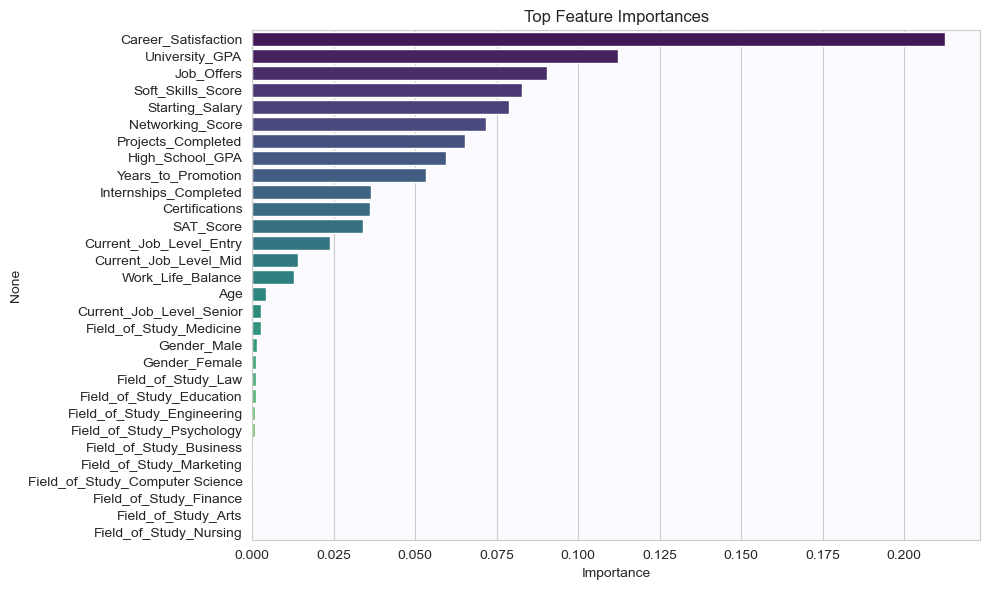

In [1]:
"""
Intern Performance Prediction - Complete Python Script """

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import joblib

# -----------------------------
# User config
# -----------------------------
DATA_PATH = "C:/Users/Abdullah Umer/Desktop/Internee.pk Internship/Task 3/Intern Performance Prediction Dataset.csv"  
TARGET_METHOD = 'career_satisfaction'  
BASE_DIR = os.path.dirname(DATA_PATH)
OUTPUT_DIR = os.path.join(BASE_DIR, 'output_results')
FIG_DIR = os.path.join(OUTPUT_DIR, 'figures')
MODEL_PATH = os.path.join(OUTPUT_DIR, 'best_model.joblib')
RANDOM_STATE = 42

os.makedirs(FIG_DIR, exist_ok=True)

# -----------------------------
# Helper functions
# -----------------------------

def load_data(path):
    df = pd.read_csv(path)
    print(f"Loaded dataset with shape: {df.shape}")
    return df


def safe_column(df, col, default=None):
    return col if col in df.columns else default


def create_performance_target(df, method='career_satisfaction'):
    """
    Create a target column 'Performance_Level' based on chosen method.
    Methods:
      - 'career_satisfaction' (default): uses Career_Satisfaction (1-10 scale) -> Low/Medium/High
      - 'job_offers': uses Job_Offers count -> 0: Low, 1-2: Medium, >=3: High
      - 'custom': user must create their own numeric score column named 'Performance_Score'
    """
    df = df.copy()
    if method == 'career_satisfaction' and 'Career_Satisfaction' in df.columns:
        bins = [df['Career_Satisfaction'].min()-1, 6, 8, df['Career_Satisfaction'].max()+1]
        labels = ['Low', 'Medium', 'High']
        df['Performance_Level'] = pd.cut(df['Career_Satisfaction'], bins=bins, labels=labels)
    elif method == 'job_offers' and 'Job_Offers' in df.columns:
        df['Performance_Level'] = pd.cut(df['Job_Offers'], bins=[-1,0,2,999], labels=['Low','Medium','High'])
    elif method == 'custom' and 'Performance_Score' in df.columns:
        df['Performance_Level'] = pd.cut(df['Performance_Score'], bins=3, labels=['Low','Medium','High'])
    else:
        # fallback: combine Job_Offers + Career_Satisfaction into a score
        score = 0
        if 'Job_Offers' in df.columns:
            score += (df['Job_Offers'] / (df['Job_Offers'].max() if df['Job_Offers'].max()>0 else 1)) * 5
        if 'Career_Satisfaction' in df.columns:
            score += (df['Career_Satisfaction'] / 10) * 5
        df['Performance_Score'] = score
        df['Performance_Level'] = pd.cut(df['Performance_Score'], bins=3, labels=['Low','Medium','High'])
    df['Performance_Level'] = df['Performance_Level'].astype('category')
    print('Performance_Level value counts:\n', df['Performance_Level'].value_counts())
    return df


# -----------------------------
# Plotting style (bright background, contrasting dark colors)
# -----------------------------

def set_plot_style():
    # Bright background
    plt.rcParams.update({
        'figure.facecolor': '#fbfbff',
        'axes.facecolor': '#fbfbff',
        'savefig.facecolor': '#fbfbff',
        'figure.figsize': (10,6),
        'axes.edgecolor': '#2b2b2b',
        'axes.labelcolor': '#2b2b2b',
        'xtick.color': '#2b2b2b',
        'ytick.color': '#2b2b2b',
    })
    sns.set_style('whitegrid', {'axes.facecolor': '#fbfbff'})


# -----------------------------
# Visualizations: create many useful figures
# -----------------------------

def create_visualizations(df):
    set_plot_style()
    # pick numeric columns automatically
    num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

    # 1. Distribution of Performance_Level
    plt.figure()
    sns.countplot(x='Performance_Level', data=df, palette=['#0b3954','#087e8b','#f08a5d'])
    plt.title('Distribution of Performance Level')
    plt.savefig(os.path.join(FIG_DIR,'01_performance_distribution.png'))

    # 2. Correlation heatmap (numeric features)
    plt.figure(figsize=(12,10))
    corr = df[num_cols].corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdYlBu', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap (numeric features)')
    plt.savefig(os.path.join(FIG_DIR,'02_correlation_heatmap.png'))

    # 3. Projects_Completed vs Performance (boxplot)
    if 'Projects_Completed' in df.columns:
        plt.figure()
        sns.boxplot(x='Performance_Level', y='Projects_Completed', data=df, palette='Dark2')
        plt.title('Projects Completed by Performance Level')
        plt.savefig(os.path.join(FIG_DIR,'03_projects_boxplot.png'))

    # 4. Internships_Completed vs Performance (boxplot)
    if 'Internships_Completed' in df.columns:
        plt.figure()
        sns.boxplot(x='Performance_Level', y='Internships_Completed', data=df, palette='Paired')
        plt.title('Internships Completed by Performance Level')
        plt.savefig(os.path.join(FIG_DIR,'04_internships_boxplot.png'))

    # 5. Soft_Skills_Score distribution by Performance
    if 'Soft_Skills_Score' in df.columns:
        plt.figure()
        sns.violinplot(x='Performance_Level', y='Soft_Skills_Score', data=df, palette=['#2b2b2b','#0b3954','#087e8b'])
        plt.title('Soft Skills Score by Performance Level')
        plt.savefig(os.path.join(FIG_DIR,'05_softskills_violin.png'))

    # 6. Scatter: University_GPA vs Projects_Completed colored by Performance
    if 'University_GPA' in df.columns and 'Projects_Completed' in df.columns:
        plt.figure()
        sns.scatterplot(x='University_GPA', y='Projects_Completed', hue='Performance_Level', data=df, palette=['#0b3954','#087e8b','#f08a5d'])
        plt.title('University GPA vs Projects Completed (colored by Performance)')
        plt.savefig(os.path.join(FIG_DIR,'06_gpa_projects_scatter.png'))

    # 7. Job_Offers by Performance (bar)
    if 'Job_Offers' in df.columns:
        plt.figure()
        sns.barplot(x='Performance_Level', y='Job_Offers', data=df, ci=None, palette='Dark2')
        plt.title('Average Job Offers by Performance Level')
        plt.savefig(os.path.join(FIG_DIR,'07_joboffers_bar.png'))

    # 8. Feature distributions (histograms) for top numeric features
    top_num = ['Projects_Completed','Internships_Completed','Certifications','Soft_Skills_Score']
    i = 8
    for col in top_num:
        if col in df.columns:
            plt.figure()
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribution of {col}')
            plt.savefig(os.path.join(FIG_DIR,f'0{i}_{col}_hist.png'))
            i += 1

    # 9. Pairplot of selected features
    selected = [c for c in ['University_GPA','Projects_Completed','Soft_Skills_Score','Certifications'] if c in df.columns]
    if len(selected) >= 2:
        try:
            sns.pairplot(df[selected + ['Performance_Level']], hue='Performance_Level', palette=['#0b3954','#087e8b','#f08a5d'])
            plt.suptitle('Pairplot (selected features)', y=1.02)
            plt.savefig(os.path.join(FIG_DIR,'11_pairplot_selected.png'))
        except Exception as e:
            print('Pairplot skipped due to:', e)

    # 10. Feature importance placeholder (after model)
    # We'll save a blank placeholder; actual feature importances will be saved by training function.
    plt.figure()
    plt.text(0.1, 0.5, 'Feature importance will appear after model training', fontsize=12)
    plt.axis('off')
    plt.savefig(os.path.join(FIG_DIR,'12_feature_importance_placeholder.png'))

    print(f"Saved figures to {FIG_DIR}")


# -----------------------------
# Preprocessing & Modeling
# -----------------------------

def build_and_evaluate(df):
    # Drop identifiers if present
    df = df.copy()
    id_col = None
    for candidate in ['Student_ID','ID','student_id','id']:
        if candidate in df.columns:
            id_col = candidate
            break
    if id_col:
        df.drop(columns=[id_col], inplace=True)

    # Drop rows with missing target
    df = df[df['Performance_Level'].notna()].copy()

    # Separate X and y
    X = df.drop(columns=['Performance_Level'])
    y = df['Performance_Level']

    # Identify numeric and categorical columns
    num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

    print('Numeric cols:', num_cols)
    print('Categorical cols:', cat_cols)

    # Simple preprocessing pipeline
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

    # Create train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

    # Model pipeline with RandomForest (recommended) and LogisticRegression for baseline
    rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))])

    lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])

    # Fit baseline logistic regression
    lr_pipeline.fit(X_train, y_train)
    y_pred_lr = lr_pipeline.predict(X_test)
    print('\nLogistic Regression Performance:')
    print(classification_report(y_test, y_pred_lr))
    print('Accuracy:', accuracy_score(y_test, y_pred_lr))

    # Fit RandomForest with simple GridSearch for n_estimators and max_depth
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [5, 10, None]
    }
    grid = GridSearchCV(rf_pipeline, param_grid, cv=3, n_jobs=-1, scoring='accuracy')
    grid.fit(X_train, y_train)
    print('\nRandom Forest best params:', grid.best_params_)
    best_rf = grid.best_estimator_

    y_pred = best_rf.predict(X_test)
    print('\nRandom Forest Performance:')
    print(classification_report(y_test, y_pred))
    print('Accuracy:', accuracy_score(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=best_rf.classes_, yticklabels=best_rf.classes_, cmap='Blues')
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
    plt.savefig(os.path.join(FIG_DIR,'confusion_matrix.png'))

    # ROC AUC - need to binarize labels
    try:
        from sklearn.preprocessing import label_binarize
        classes = np.unique(y)
        y_test_bin = label_binarize(y_test, classes=classes)
        y_score = best_rf.predict_proba(X_test)
        # Compute ROC AUC (macro)
        roc_auc = roc_auc_score(y_test_bin, y_score, average='macro')
        print('ROC AUC (macro):', roc_auc)

        # Plot ROC curves for each class
        plt.figure(figsize=(8,6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, label=f'{cls} (AUC {roc_auc:.2f})')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
        plt.legend();
        plt.savefig(os.path.join(FIG_DIR,'roc_curves.png'))
    except Exception as e:
        print('ROC AUC skipped due to:', e)

    # Feature importance (works when preprocessor output is numeric + onehot)
    try:
        # get feature names from preprocessor
        ohe_cols = []
        if 'cat' in preprocessor.named_transformers_:
            ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
            cat_names = ohe.get_feature_names_out(cat_cols)
            ohe_cols = cat_names.tolist()
        feature_names = num_cols + ohe_cols
        importances = best_rf.named_steps['classifier'].feature_importances_
        feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
        plt.figure(figsize=(10,6))
        sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
        plt.title('Top Feature Importances')
        plt.xlabel('Importance');
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR,'feature_importances.png'))
        print('\nTop feature importances:\n', feat_imp)
    except Exception as e:
        print('Feature importance plotting skipped due to:', e)

    # Save best model
    joblib.dump(best_rf, MODEL_PATH)
    print(f"Saved best model to {MODEL_PATH}")


# -----------------------------
# Main flow
# -----------------------------

def main():
    if not os.path.exists(DATA_PATH):
        print(f"Data file not found at {DATA_PATH}. Please place the CSV in the script folder or update DATA_PATH.")
        return

    df = load_data(DATA_PATH)

    # Quick look
    print('\nColumns:', df.columns.tolist())
    print('\nSample rows:\n', df.head())

    # Create target
    df = create_performance_target(df, method='career_satisfaction')

    # Visualizations (saves many figures)
    create_visualizations(df)

    # Model building & evaluation
    build_and_evaluate(df)

    print('\nAll done. Check the output_results folder for figures and trained model.')


if __name__ == '__main__':
    main()







